In [1]:
import math 

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BASE_PATH = '/Users/vinay/ub/spring-22/CSE573-CVIP/BackgroundStitching/images'

In [3]:
sift = cv2.SIFT_create()

class Recognition:
    def __init__(self, feature_detector):
        self.feature_detector = feature_detector
        self.bf = cv2.BFMatcher()
        
    def get_features(self, img):
        return self.feature_detector.detectAndCompute(img, None)
        
    def match_bf(self, img1, img2, n=20, l_thickness=2):
        kp_1, dsc_1 = self.get_features(img1)
        kp_2, dsc_2 = self.get_features(img2)
        
        matches = self.bf.match(dsc_1, dsc_2)
        matches = sorted(matches, key = lambda x:x.distance, reverse=False)

        img = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:n+1], None, flags=2, matchesThickness=l_thickness)
        
        return (matches, (kp_1, kp_2)), img
    
    def match_f(self, img1, img2, n=20, r=0.7, l_thickness=2):
        kp_1, dsc_1 = self.get_features(img1)
        kp_2, dsc_2 = self.get_features(img2)
        
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(dsc_1, dsc_2, k=2)
        good_matches = []
        
        for p, q in matches:
            if p.distance < r * q.distance:
                good_matches.append(p)
        
        img = cv2.drawMatches(img1, kp_1, img2, kp_2, good_matches[:n+1], None, flags=2, matchesThickness=l_thickness)
        
        return (good_matches, (kp_1, kp_2)), img
    
recog = Recognition(sift)

def compute_homography(args, img1, img2, min_matches=5):
    img1 = img1.copy()
    img2 = img2.copy()
    (matches, (kp1, kp2)) = args
    
    assert len(matches) >= min_matches, f'Need at least {min_matches} matches'

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
    matchesMask = mask.ravel().tolist()

    h, w = img1.shape
    pts = np.float32([ [0, 0],[0, h-1],[w-1, h-1],[w-1, 0] ]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, homography)
    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    draw_params = dict(
        matchColor = (0,255,0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matchesMask, # draw only inliers
        flags = 2,
    )
    op = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)
    
    return dst, mask, homography, op
        
    
def transform_c(coordinates, homography):
    x, y, w, h = coordinates
    src = np.float32([[x, y], [x, y + h - 1], [x + w - 1, y], [x + w - 1, y + h - 1]]).reshape(-1, 1, 2)
    
    dst = cv2.perspectiveTransform(src, homography)
    l, _, _ = dst.shape
    dst = dst.reshape((l, 2))
    
    min_x, max_x = np.min(dst[:, 0]), np.max(dst[:, 0])
    min_y, max_y = np.min(dst[:, 1]), np.max(dst[:, 1])
    
    new_x = int(np.floor(min_x))
    new_y = int(np.floor(min_y))
    new_w = int(np.ceil(max_x - min_x))
    new_h = int(np.ceil(max_y - min_y))
    
    return new_x, new_y, new_w, new_h

def shape(img):
    s = img.shape
    a = 0
    if len(s) == 3:
        h, w, a = img.shape
    else:
        h, w = img.shape
        
    return h, w, a

def get_new_c(c, homography):
    return np.floor(cv2.perspectiveTransform(np.float32(c).reshape(-1, 1, 2), homography))

def img2c(img):
    size = img.shape
    return (0, 0, size[1], size[0])

def translate_homography(dx, dy, H):
    dx, dy = abs(dx) if dx < 0 else 0, abs(dy) if dy < 0 else 0
    transform = np.float32(
        [
            [1, 0, dx],
            [0, 1, dy],
            [0, 0,  1],
        ]
    )
    new_h = transform.dot(H)
    return new_h, (dx, dy)

def resize(img, factor):
    h, w, a = shape(img)
    op = cv2.resize(img, (int(w*factor), int(h*factor)))
    return op

def show(img, dpi=100, disable_axis=True, color=True):
    if color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    plt.figure(dpi=dpi)
    plt.imshow(img, cmap='gray')
    
    if disable_axis:
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

In [4]:
# img1_c = cv2.imread(f'{BASE_PATH}/left_k.JPG')
# img2_c = cv2.imread(f'{BASE_PATH}/right_k.JPG')

img1_c = cv2.imread(f'{BASE_PATH}/t1_1.png')
img2_c = cv2.imread(f'{BASE_PATH}/t1_2.png')

# img1_c = cv2.imread(f'{BASE_PATH}/left_1.png')
# img2_c = cv2.imread(f'{BASE_PATH}/right_1.png')

# img1_c = cv2.imread(f'{BASE_PATH}/left_3.png')
# img2_c = cv2.imread(f'{BASE_PATH}/right_3.png')

# img1_c = cv2.imread(f'{BASE_PATH}/left_4.png')
# img2_c = cv2.imread(f'{BASE_PATH}/right_4.png')

img1 = cv2.cvtColor(img1_c, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_c, cv2.COLOR_BGR2GRAY)

h1, w1 = img1.shape
h2, w2 = img2.shape

scale_factor = 1.0

if scale_factor != 1.0:
    img1 = resize(img1, scale_factor)
    img2 = resize(img2, scale_factor)
    
    img1_c = resize(img1_c, scale_factor)
    img2_c = resize(img2_c, scale_factor)

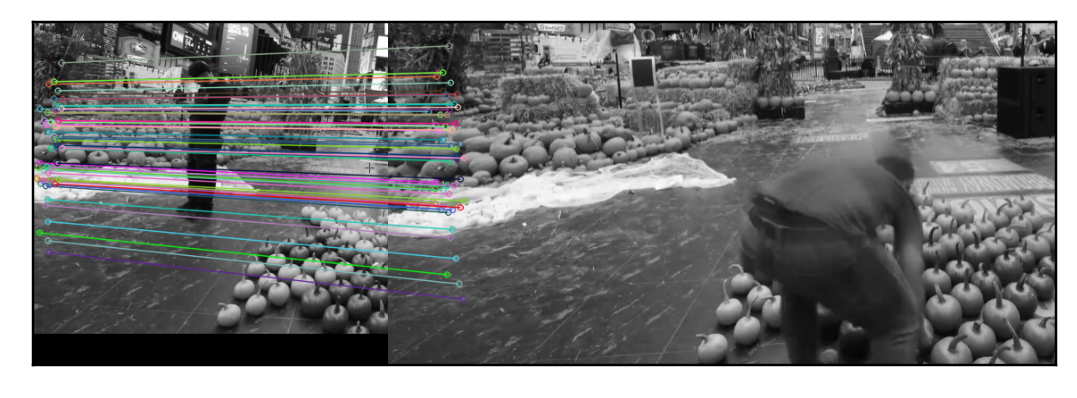

In [5]:
(matches, (kp1, kp2)), match_img = recog.match_f(img1, img2, 50, 0.60, 1)
show(match_img, dpi=220)

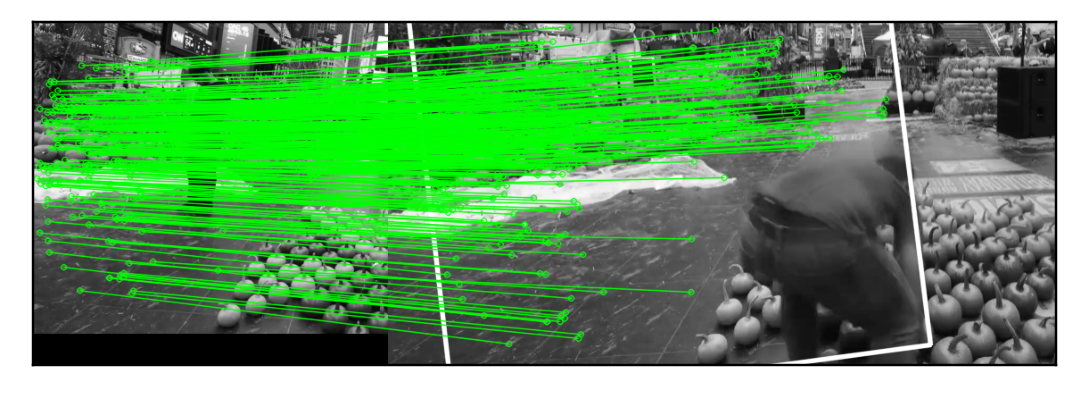

In [6]:
dst, mask, H, h_img = compute_homography((matches, (kp1, kp2)), img1, img2)
show(h_img, dpi=220)

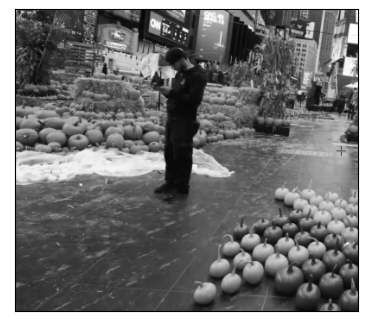

In [7]:
show(img1, dpi=100)

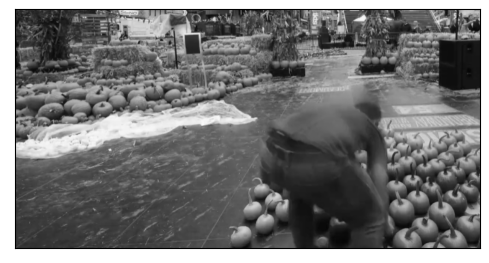

In [8]:
show(img2, dpi=100)

In [9]:
def warp(img1, img2, H):
    _, _, a = shape(img1)
    dx, dy, dw, dh = transform_c(img2c(img1), H)
    new_H, (tx, ty) = translate_homography(dx, dy, H)
    x, y, w, h = transform_c(img2c(img1), new_H)
    width, height = max(tx + img2.shape[1], x+w), max(ty + img2.shape[0], y+h)


    warped_img1 = cv2.warpPerspective(img1, new_H, (width, height))
    result = warped_img1.copy()
    result[ty:ty+img2.shape[0], tx:tx+img2.shape[1]] = img2
    if a:
        warped_img2 = np.zeros((height, width, a), dtype=np.uint8)
        warped_img2[ty:ty+img2.shape[0], tx:tx+img2.shape[1], :] = img2
    else:
        warped_img2 = np.zeros((height, width), dtype=np.uint8)
        warped_img2[ty:ty+img2.shape[0], tx:tx+img2.shape[1]] = img2
    
    return warped_img1, warped_img2, result

In [10]:
img1.shape, img1_c.shape

((350, 398), (350, 398, 3))

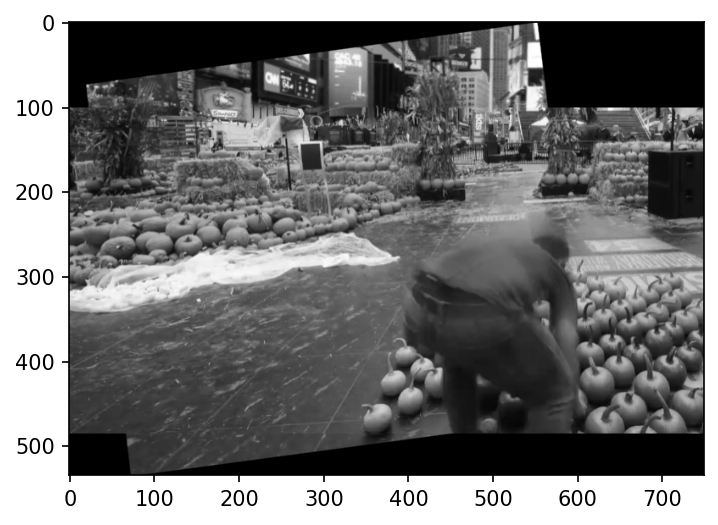

In [11]:
w_img1, w_img2, warped_img = warp(img1, img2, H)
show(warped_img, dpi=150, disable_axis=False)

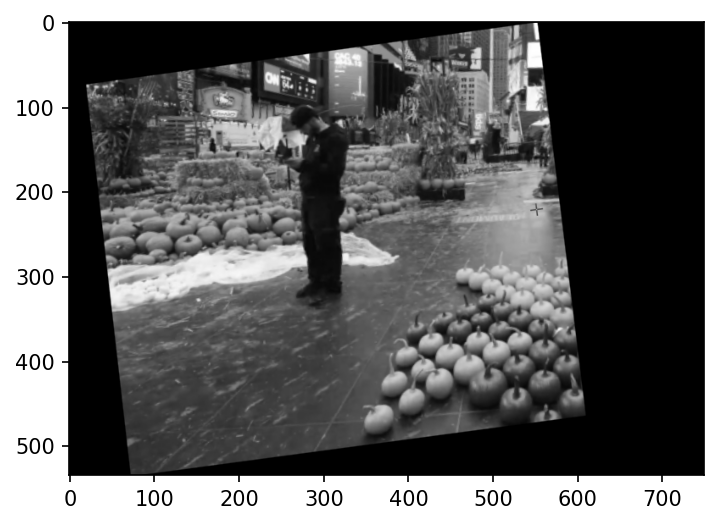

In [12]:
show(w_img1, dpi=150, disable_axis=False)

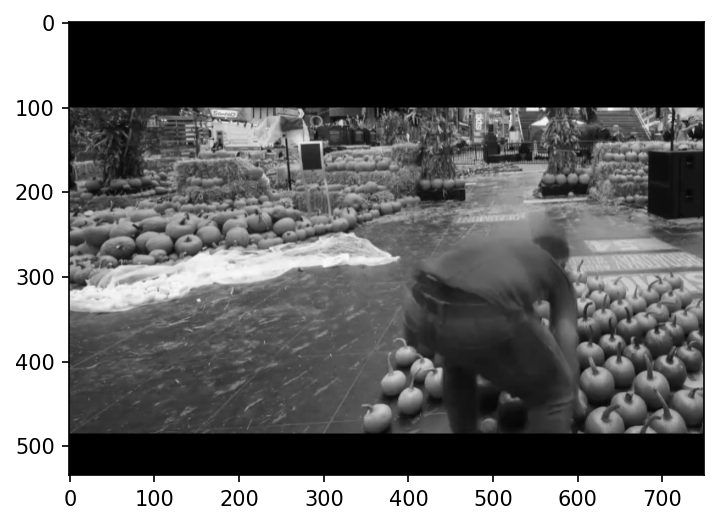

In [13]:
show(w_img2, dpi=150, disable_axis=False)

In [14]:
def overlap_region(w_img1, w_img2):
    mask = np.logical_and(
        w_img1,
        w_img2,
    ).astype('int8')
    intersection = np.argwhere(mask == True)

    max_dims = np.max(intersection, axis=0)
    min_dims = np.min(intersection, axis=0)

    y_max, x_max = max_dims[0], max_dims[1]
    y_min, x_min = min_dims[0], min_dims[1]
    
    return mask, (x_max, y_max, x_min, y_min)

In [15]:
overlap_mask, (x_max, y_max, x_min, y_min) = overlap_region(w_img1, w_img2)
x_max, y_max, x_min, y_min 

(609, 485, 23, 101)

In [16]:
def apply_mask(mask, img1, img2, p=0.95):
    mask1 = mask.copy()
    mask2 = mask.copy()
    
    mask1[mask == 0] = p
    mask1[mask == 1] = 0
    
    # print(np.unique(mask1), np.unique(mask2))
    
    mask2[mask == 1] = 1-p
    mask2[mask == 0] = 0
    
    # print(np.unique(mask1), np.unique(mask2))
    
    img1[img1 == 0] = img2[img1 == 0]
    img2[img2 == 0] = img1[img2 == 0]
    
    img = (img1 * mask1) + (img2 * mask2)

    return img

In [17]:
def select(img1, img2, mask, thresh=5):
    h, w, a = shape(img1)
    if a:
        img_mask = np.ones((h, w, a))
    else:
        img_mask = np.ones((h, w))
        
    l = []
    
    # ignore empty image space
    for p in range(w):
        n1 = (img1[:, p] == 0.0).sum()
        n2 = (img2[:, p] == 0.0).sum()
        
        if n1 > 0 or n2 > 0:
            break
    
    
    for i in range(p, w):
        n1 = (img1[:, i] == 0).sum()
        n2 = (img2[:, i] == 0).sum()
        img1_col = img1[:, i]
        img2_col = img2[:, i]
       
        if i == p:
            if n1 < n2:
                ref_col = img1_col
                last = 1
                flag = False
            else:
                ref_col = img2_col
                last = 2
                flag = True
        else:
            # select pixels in the overlap region and find difference
            d1 = int(((img1_col * mask[:, i] - ref_col * mask[:, i-1])).sum())
            d2 = int(((img2_col * mask[:, i] - ref_col *  mask[:, i-1])).sum())

            if d1 < d2:
                if last == 2:
                    if l and i - l[-1] < thresh:
                        l.pop()
                    else:
                        l.append(i)
                    last = 1
                ref_col = img1_col
            else:
                if last == 1:
                    if l and i - l[-1] < thresh:
                        l.pop()
                    else:
                        l.append(i)
                    last = 2
                ref_col = img2_col
                    
    l.append(i)
    k = 0
    
    for x in l:
        img_mask[:, k:x+1] = flag
        flag = not flag
        k = x
        
    return l, np.logical_not(img_mask)

In [18]:
def merge(img1, img2, x_min, y_min, x_max, y_max, mask, thresh=3, pad=5):
    h, w, a = shape(img1)
    mask_r = np.zeros_like(img1, dtype=bool)
    
    # print(f'mask: {shape(mask)}')
        
    x_min_n = max(x_min-pad, 0)
    y_min_n = max(y_min-pad, 0)
    x_max_n = min(x_max+pad, w)
    y_max_n = min(y_max+pad, h)
    
    # print(f'x_min: {x_min, x_min_n}, y_min: {y_min, y_min_n}, x_max: {x_max, x_max_n}, y_max: {y_max, y_max_n}')
    
    # print(f'before: img1: {shape(img1[y_min:y_max+1, x_min:x_max+1])}, img2: {shape(img2[y_min:y_max+1, x_min:x_max+1])}, mask: {shape(mask[y_min:y_max+1, x_min:x_max+1])}')
    
    img1 = img1[y_min_n:y_max_n+1, x_min_n:x_max_n+1]
    img2 = img2[y_min_n:y_max_n+1, x_min_n:x_max_n+1]
    mask = mask[y_min_n:y_max_n+1, x_min_n:x_max_n+1]
    
    # print(f'after: img1: {shape(img1)}, img2: {shape(img2)}, mask: {shape(mask)}')
    
    l, main_mask = select(img1, img2, mask=mask, thresh=thresh)
    k = 0
    temp = []
    
    for x in l[1:]:
        sub_img1 = img1[:, k:x+1]
        sub_img2 = img2[:, k:x+1]
        new_mask = mask[:, k:x+1]
        
        if a:
            sub_img1 = sub_img1.transpose((1, 0, 2))
            sub_img2 = sub_img2.transpose((1, 0, 2))
            new_mask = new_mask.transpose((1, 0, 2))
        else:
            sub_img1 = sub_img1.T
            sub_img2 = sub_img2.T
            new_mask = new_mask.T
        
        _, sub_mask = select(
            sub_img1,
            sub_img2,
            new_mask,
            thresh=thresh,
        )
            
        if a:
            sub_mask = sub_mask.transpose((1, 0, 2))
            sub_img1 = sub_img1.transpose((1, 0, 2))
            sub_img2 = sub_img2.transpose((1, 0, 2))
        else:
            sub_mask = sub_mask.T
            sub_img1 = sub_img1.T
            sub_img2 = sub_img2.T

        main_mask[:, k:x+1] = sub_mask
        k = x
        
    mask_r[y_min_n:y_max_n+1, x_min_n:x_max_n+1] = main_mask
    
    return mask_r[y_min:y_max+1, x_min:x_max+1]
    
    
main_mask = merge(
    w_img1, 
    w_img2,
    x_min, y_min, x_max, y_max,
    overlap_mask,
    thresh=5,
)
        
# print(main_mask.shape, w_img1[y_min:y_max+1, x_min:x_max+1].shape, w_img2[y_min:y_max+1, x_min:x_max+1].shape)
        
result = apply_mask(
    main_mask,
    w_img1[y_min:y_max+1, x_min:x_max+1],
    w_img2[y_min:y_max+1, x_min:x_max+1],
)

warped_img[y_min:y_max+1, x_min:x_max+1] = result

In [19]:
def stitch(img1_c, img2_c):
    img1 = cv2.cvtColor(img1_c, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_c, cv2.COLOR_BGR2GRAY)
    
    (matches, (kp1, kp2)), match_img = recog.match_f(img1, img2, 50, 0.60, 1)
    dst, mask, H, h_img = compute_homography((matches, (kp1, kp2)), img1, img2)
    
    w_img1, w_img2, warped_img = warp(img1_c, img2_c, H)
    overlap_mask, (x_max, y_max, x_min, y_min) = overlap_region(w_img1, w_img2)
    main_mask = merge(
        w_img1, 
        w_img2,
        x_min, y_min, x_max, y_max,
        overlap_mask,
        thresh=5,
    )
    result = apply_mask(
        main_mask,
        w_img1[y_min:y_max+1, x_min:x_max+1],
        w_img2[y_min:y_max+1, x_min:x_max+1],
    )

    warped_img[y_min:y_max+1, x_min:x_max+1] = result
    
    return warped_img

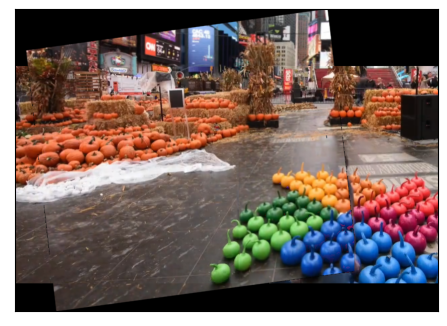

In [20]:
show(stitch(img1_c, img2_c))

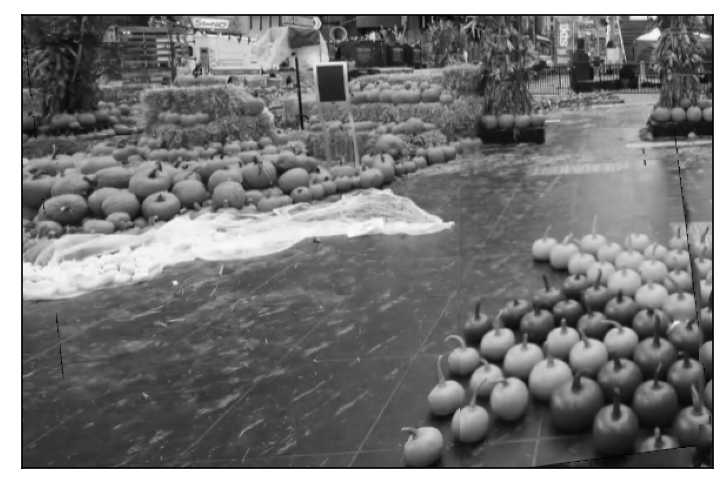

In [21]:
show(result, dpi=150)

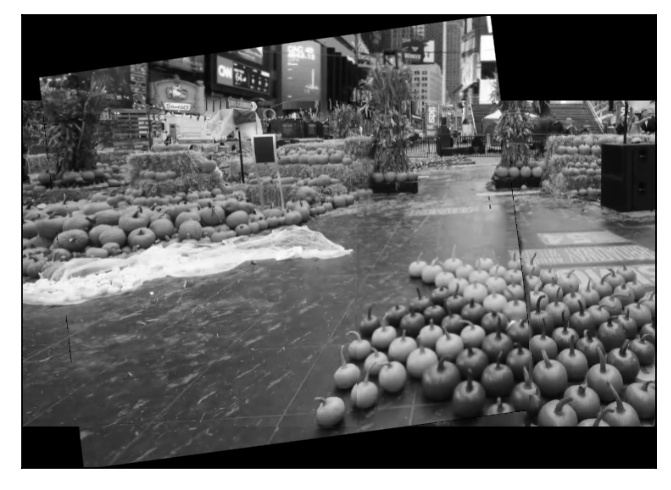

In [22]:
show(warped_img, dpi=150)

In [23]:
# plt.figure(dpi=150)
# plt.imshow(main_mask[:, :, 0], cmap='gray')
# plt.imshow(main_mask, cmap='gray')